In [1]:
import numpy as np
import re

In [2]:
from utility.clean_data_func import clean_and_filter_data


def remove_special_characters(text):
    """Removes special characters from a text string."""
    pattern = r"[^\w\s]"  # Keep alphanumeric characters and whitespace
    return re.sub(pattern, "", text)


def lowercase(text):
    """Converts a text string to lowercase."""
    return text.lower()


# Clean data
print("Clean data")
df = clean_and_filter_data("./utility/azarbeijan-reviews.csv")
df["content"] = df["content"].apply(remove_special_characters)
df["content"] = df["content"].apply(lowercase)

# Separate target and data
print("Separate target and data")
content = df["content"].values.tolist()
score = df["score"].values.tolist()

# Split the dataset into training and testing sets
print("Split the dataset into training and testing sets")
split_point = int(len(content) * 0.80)
train_content, test_content = content[:split_point], content[split_point:]
train_score, test_score = score[:split_point], score[split_point:]

Clean data
                                             content  score  upvotes
0                                          Çox qəşəy      5        0
1  Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2  Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                          cox gözəl      5        1
4  Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127537 entries, 0 to 127536
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  127534 non-null  object
 1   score    127537 non-null  int64 
 2   upvotes  127537 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB
None
content    3
score      0
upvotes    0
dtype: int64
Separate target and data
Split the dataset into training and testing sets


In [3]:
import numpy as np

def load_glove_model(glove_file):
    print("Loading GloVe Model")
    with open(glove_file, 'r', encoding='utf-8') as f:
        embeddings_index = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            embeddings_index[word] = embedding
    print("Done.", len(embeddings_index), " words loaded!")
    return embeddings_index

glove_path = './glove.6B.100d.txt'
glove_model = load_glove_model(glove_path)


Loading GloVe Model
Done. 400000  words loaded!


In [4]:
def sentence_vector(sentence, model):
    words = sentence.split()  # Assuming default whitespace tokenization
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        # If no words in the sentence are in the model, return zero vector.
        return np.zeros(len(model[next(iter(model))]))
    return np.mean(word_vectors, axis=0)

# Apply this function to each row in the DataFrame
df['vector'] = df['content'].apply(lambda x: sentence_vector(x, glove_model))

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Example assumes 'score' needs to be encoded for classification
encoder = LabelEncoder()
encoded_scores = encoder.fit_transform(df['score'])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['vector'].values), encoded_scores, test_size=0.2, random_state=42)


In [6]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(encoded_scores)), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/Users/hasaneke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.5623 - loss: 1.1887 - val_accuracy: 0.6169 - val_loss: 1.0321
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.5992 - loss: 1.1101 - val_accuracy: 0.6169 - val_loss: 1.0293
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6089 - loss: 1.0741 - val_accuracy: 0.6169 - val_loss: 1.0274
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6180 - loss: 1.0533 - val_accuracy: 0.6169 - val_loss: 1.0342
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6062 - loss: 1.0673 - val_accuracy: 0.6184 - val_loss: 1.0286
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6097 - loss: 1.0530 - val_accuracy: 0.6169 - val_loss: 1.0263
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6126 - loss: 1.0379 - val_accuracy: 0.6180 - val_loss: 1.0266
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6123 - loss: 1.0533 - 

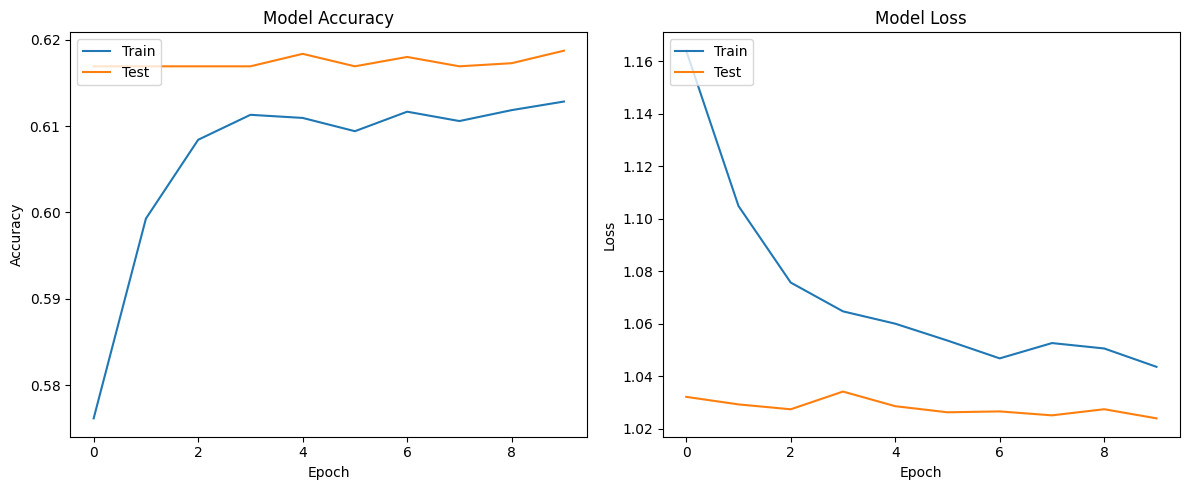

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
